In [7]:
import gdrive_refs as gdrive
import zipfile
from utils import *
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data Fetching

Using DataHub and `utils.py` to collect relevant datasets. We will store the datasets into a dictonary to facilitate data collection. 

We start by fetching specific csv files from a Google Drive

In [107]:
for gdrive_file in gdrive.gdrive_dic:
    print(f'starting download of: {gdrive_file[1]}')
    gdrive_id, file = gdrive_file[0], gdrive_file[1]
    fetch_and_cache_gdrive(gdrive_id, file, data_dir="./../data", force=False)

starting download of: pm25National.csv
Using cached version that was downloaded (UTC): Fri Apr 15 17:07:37 2022
starting download of: ozone_2000.csv
Using cached version that was downloaded (UTC): Wed May 11 16:57:40 2022
starting download of: ozone_2001.csv
Using cached version that was downloaded (UTC): Wed May 11 16:57:45 2022
starting download of: ozone_2002.csv
Using cached version that was downloaded (UTC): Wed May 11 16:57:49 2022
starting download of: ozone_2003.csv
Using cached version that was downloaded (UTC): Wed May 11 16:57:53 2022
starting download of: ozone_2004.csv
Using cached version that was downloaded (UTC): Wed May 11 16:57:57 2022
starting download of: ozone_2005.csv
Using cached version that was downloaded (UTC): Wed May 11 16:58:01 2022
starting download of: ozone_2006.csv
Using cached version that was downloaded (UTC): Wed May 11 16:58:05 2022
starting download of: ozone_2007.csv
Using cached version that was downloaded (UTC): Wed May 11 16:58:10 2022
starting

We then fetch `.zip` files from the EPA and convert them into csv

In [108]:
#Years we want to collect from online sources
years = [str(i) for i in range(2000,2021)]

#EPA identifies pollutants with a 5-digit unique indentifier
epa_pollutants_codes = ["44201","42401","42101","42602"]

# Creating a list of urls from which to fetch the corresponing zip file
url = ["https://aqs.epa.gov/aqsweb/airdata/daily_"+epa_pollutants_codes[i]+"_"+years[j]+".zip" for i in range(len(epa_pollutants_codes)) for j in range(len(years))]
url = url + ["https://aqs.epa.gov/aqsweb/airdata/annual_aqi_by_county_"+years[j]+".zip" for j in range(len(years))]
url

['https://aqs.epa.gov/aqsweb/airdata/daily_44201_2000.zip',
 'https://aqs.epa.gov/aqsweb/airdata/daily_44201_2001.zip',
 'https://aqs.epa.gov/aqsweb/airdata/daily_44201_2002.zip',
 'https://aqs.epa.gov/aqsweb/airdata/daily_44201_2003.zip',
 'https://aqs.epa.gov/aqsweb/airdata/daily_44201_2004.zip',
 'https://aqs.epa.gov/aqsweb/airdata/daily_44201_2005.zip',
 'https://aqs.epa.gov/aqsweb/airdata/daily_44201_2006.zip',
 'https://aqs.epa.gov/aqsweb/airdata/daily_44201_2007.zip',
 'https://aqs.epa.gov/aqsweb/airdata/daily_44201_2008.zip',
 'https://aqs.epa.gov/aqsweb/airdata/daily_44201_2009.zip',
 'https://aqs.epa.gov/aqsweb/airdata/daily_44201_2010.zip',
 'https://aqs.epa.gov/aqsweb/airdata/daily_44201_2011.zip',
 'https://aqs.epa.gov/aqsweb/airdata/daily_44201_2012.zip',
 'https://aqs.epa.gov/aqsweb/airdata/daily_44201_2013.zip',
 'https://aqs.epa.gov/aqsweb/airdata/daily_44201_2014.zip',
 'https://aqs.epa.gov/aqsweb/airdata/daily_44201_2015.zip',
 'https://aqs.epa.gov/aqsweb/airdata/dai

### Careful this next one takes a long time to run ($\approx 5$ mins)!
Fetching `.zip` files from the EPA website and converting them into a `.csv`.

In [112]:
def processing_url_fetch(url):
    for data_url in url:
        data_dir="./../data"
        if '44201' in data_url:
            zip_file = 'ozone_'+data_url[-8:-3]+'zip'
            csv_file = 'ozone_'+data_url[-8:-3]+'csv'
            fetch_and_cache(data_url, zip_file, data_dir, force=False)
            with zipfile.ZipFile(data_dir+'/'+zip_file, 'r') as zip_ref:
                zip_ref.extractall(path = data_dir)
                try:
                    os.remove(data_dir+'/'+zip_file)
                    os.rename(data_dir+'/'+data_url[-20:-3]+'csv', data_dir+'/'+csv_file)
                except:
                    None
            print("Processed {}".format(csv_file))
        if '42401' in data_url:
            zip_file = 'so2_'+data_url[-8:-3]+'zip'
            csv_file = 'so2_'+data_url[-8:-3]+'csv'
            fetch_and_cache(data_url, zip_file, data_dir, force=False)
            with zipfile.ZipFile(data_dir+'/'+zip_file, 'r') as zip_ref:
                zip_ref.extractall(path = data_dir)
                try:
                    os.remove(data_dir+'/'+zip_file)
                    os.rename(data_dir+'/'+data_url[-20:-3]+'csv', data_dir+'/'+csv_file)
                except:
                    None
            print("Processed {}".format(csv_file))
        if '42101' in data_url:
            zip_file = 'co_'+data_url[-8:-3]+'zip'
            csv_file = 'co_'+data_url[-8:-3]+'csv'
            fetch_and_cache(data_url, zip_file, data_dir, force=False)
            with zipfile.ZipFile(data_dir+'/'+zip_file, 'r') as zip_ref:
                zip_ref.extractall(path = data_dir)
                try:
                    os.remove(data_dir+'/'+zip_file)
                    os.rename(data_dir+'/'+data_url[-20:-3]+'csv', data_dir+'/'+csv_file)
                except:
                    None
            print("Processed {}".format(csv_file))
        if '42602' in data_url:
            zip_file = 'no2_'+data_url[-8:-3]+'zip'
            csv_file = 'no2_'+data_url[-8:-3]+'csv'
            fetch_and_cache(data_url, zip_file, data_dir, force=False)
            with zipfile.ZipFile(data_dir+'/'+zip_file, 'r') as zip_ref:
                zip_ref.extractall(path = data_dir)
                try:
                    os.remove(data_dir+'/'+zip_file)
                    os.rename(data_dir+'/'+data_url[-20:-3]+'csv', data_dir+'/'+csv_file)
                except:
                    None
            print("Processed {}".format(csv_file))
        if 'annual_aqi_by_county' in data_url:
            zip_file = 'annual_aqi_by_county_'+data_url[-8:-3]+'zip'
            csv_file = 'annual_aqi_by_county_'+data_url[-8:-3]+'csv'
            fetch_and_cache(data_url, zip_file, data_dir, force=False)
            with zipfile.ZipFile(data_dir+'/'+zip_file, 'r') as zip_ref:
                zip_ref.extractall(path = data_dir)
                try:
                    os.remove(data_dir+'/'+zip_file)
                    os.rename(data_dir+'/'+data_url[-20:-3]+'csv', data_dir+'/'+csv_file)
                except:
                    None
            print("Processed {}".format(csv_file))

processing_url_fetch(url)

Downloading... Done!
Processed ozone_2000.csv
Downloading... Done!
Processed ozone_2001.csv
Downloading... Done!


KeyboardInterrupt: 

# Predicting deaths

We saw in the `relating_aqi_pm25` notebook that there is not correlation between $AQI$ and $PM2.5$ with the dataset provided by EPA. We concluded that the correlation itself is not linear and also depends on other factors such that $PM10$ and pollutant concentration in the air. This way, we want to create a predictor of deaths attributed to air pollution with the sole values of:
- $AQI$
- $PM2.5$
- Concentrations of $CO$, $SO_2$, $O_3$ (ozone) and $NO_2$

To do this, we will center our analysis on the data provided by the World Health Organization and the EPA to build a predictor that can accurately predict the yearly death tolls on the US alone.

# Building the table

Let us join the tables comprising the Median $AQI$, $PM2.5$, and the $AQI$ of each pollutant.

#### $PM2.5$

In [113]:
pm25 = pd.read_csv('./../data/pm25National.csv')
# We only take the years 2000 to 2016
pm25_filtered = pm25[(pm25['Year']>=2000) & (pm25['Year']<=2020)].loc[:,['Year','Mean']].rename(columns = {'Mean':'PM2.5 Mean'})
pm25_filtered

,Year,PM2.5 Mean
0,2000,13.497383
1,2001,13.225067
2,2002,12.827120
3,2003,12.332006
4,2004,12.023175
5,2005,12.868947
6,2006,11.622669
7,2007,11.920433
8,2008,10.891642
9,2009,9.883770


#### Median AQI

In [115]:
years = [str(i) for i in range(2001,2021)]
annual_aqi_us_county = pd.read_csv("./../data/annual_aqi_by_county_2000.csv").loc[:,['Year', 'State', 'County','Median AQI']]
increment = 1
for year in years:
    df = pd.read_csv("./../data/annual_aqi_by_county_"+year+".csv").loc[:,['Year', 'State', 'County','Median AQI']]
    annual_aqi_us_county = pd.concat([annual_aqi_us_county, df], axis=0)
    increment += 1
annual_aqi_us_county = annual_aqi_us_county.reset_index().drop(columns='index')
annual_aqi_us_filtered = annual_aqi_us_county.groupby('Year').mean().reset_index()
annual_aqi_us_filtered

,Year,Median AQI
0,2000,39.700441
1,2001,39.335074
2,2002,38.721453
3,2003,38.533104
4,2004,37.500871
5,2005,39.577797
6,2006,38.954464
7,2007,40.444946
8,2008,38.860000
9,2009,36.533212


Now we load the datasets for air pollutants AQIs (which we know are related to air concentration).

#### Interlude

Showing the data cleaning we do all pollutant concentrations

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351585 entries, 0 to 351584
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   State Code           351585 non-null  int64  
 1   County Code          351585 non-null  int64  
 2   Site Num             351585 non-null  int64  
 3   Parameter Code       351585 non-null  int64  
 4   POC                  351585 non-null  int64  
 5   Latitude             351585 non-null  float64
 6   Longitude            351585 non-null  float64
 7   Datum                351585 non-null  object 
 8   Parameter Name       351585 non-null  object 
 9   Sample Duration      351585 non-null  object 
 10  Pollutant Standard   351585 non-null  object 
 11  Date Local           351585 non-null  object 
 12  Units of Measure     351585 non-null  object 
 13  Event Type           351585 non-null  object 
 14  Observation Count    351585 non-null  int64  
 15  Observation Perce

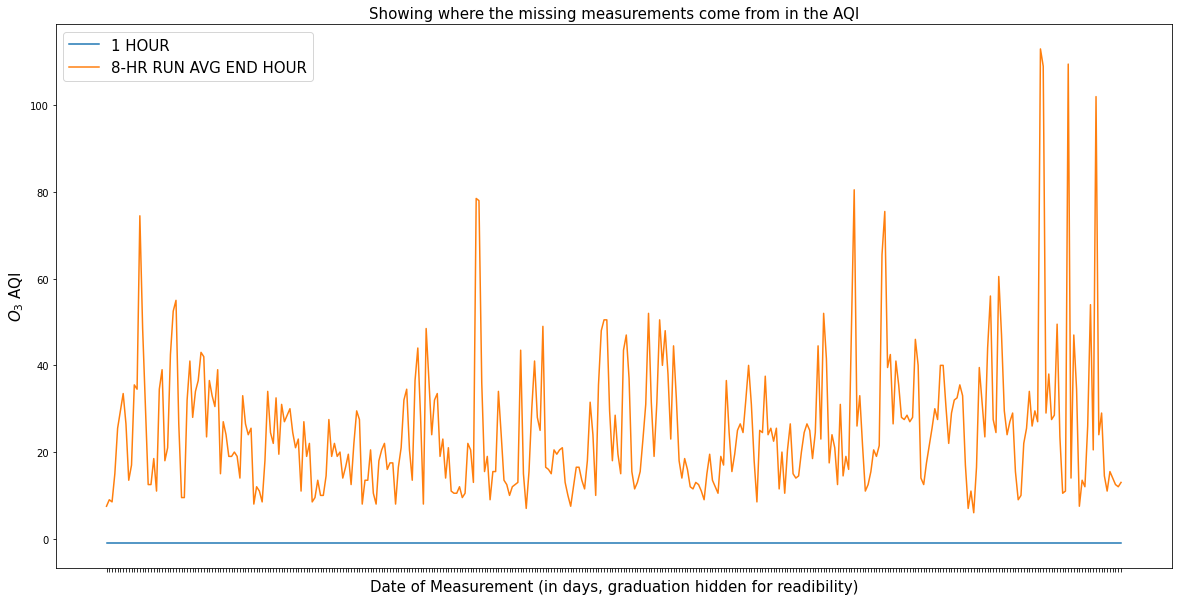

In [116]:
co_concentration = pd.read_csv('./../data/co_2000.csv')

co_concentration.info()
plt.figure(figsize=(20,10))
ax = sns.lineplot(data = co_concentration.loc[co_concentration['City Name']=='Birmingham',:].fillna(-1), x = 'Date Local', y = 'AQI', hue = 'Sample Duration', ci=None)
ax.set(xticklabels=[])
plt.title('Showing where the missing measurements come from in the AQI', fontsize = 15)
plt.xlabel('Date of Measurement (in days, graduation hidden for readibility)', fontsize = 15)
plt.ylabel('$O_3$ AQI', fontsize = 15)
plt.legend(fontsize=15)
plt.show()

... the plot above perfectly shows that the missing data is only contained in the 1-hour window measurements. Fortunately, no further processing is required.

#### $CO$ AQI

In [117]:
co_concentration = co_concentration.loc[pd.notna(co_concentration['AQI']),['AQI']].mean().reset_index().rename(columns={0: "CO AQI"}).drop(columns='index')
co_concentration['Year'] = pd.Series(2000)

years = [str(i) for i in range(2001,2021)]
for year in years:
    df = pd.read_csv('./../data/co_'+year+'.csv')
    df = df.loc[pd.notna(df['AQI']),['AQI']].mean().reset_index().rename(columns={0: "CO AQI"}).drop(columns='index')
    df['Year'] = pd.Series(int(year))
    co_concentration = pd.concat([co_concentration, df], axis=0)
co_concentration

/Users/aymeric/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,CO AQI,Year
0,12.536678,2000
0,11.818071,2001
0,10.889842,2002
0,10.349962,2003
0,9.350434,2004
0,8.662587,2005
0,8.126856,2006
0,7.137915,2007
0,6.471224,2008
0,6.055578,2009


#### $NO_2$ AQI

In [118]:
no2_concentration = pd.read_csv('./../data/no2_2000.csv') 
no2_concentration = no2_concentration.loc[pd.notna(no2_concentration['AQI']),['AQI']].mean().reset_index().rename(columns={0: "NO2 AQI"}).drop(columns='index')
no2_concentration['Year'] = pd.Series(2000)

years = [str(i) for i in range(2001,2021)]
for year in years:
    df = pd.read_csv('./../data/no2_'+year+'.csv')
    df = df.loc[pd.notna(df['AQI']),['AQI']].mean().reset_index().rename(columns={0: "NO2 AQI"}).drop(columns='index')
    df['Year'] = pd.Series(int(year))
    no2_concentration = pd.concat([no2_concentration, df], axis=0)
no2_concentration

/Users/aymeric/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/aymeric/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,NO2 AQI,Year
0,27.491528,2000
0,26.929423,2001
0,25.932520,2002
0,25.004868,2003
0,23.438959,2004
0,23.754289,2005
0,22.775990,2006
0,21.902248,2007
0,21.095123,2008
0,19.085690,2009


#### $O_3$ (Ozone) AQI

In [119]:
ozone_concentration = pd.read_csv('./../data/ozone_2000.csv') 
ozone_concentration = ozone_concentration.loc[pd.notna(ozone_concentration['AQI']),['AQI']].mean().reset_index().rename(columns={0: "Ozone AQI"}).drop(columns='index')
ozone_concentration['Year'] = pd.Series(2000)

years = [str(i) for i in range(2001,2021)]
for year in years:
    df = pd.read_csv('./../data/ozone_'+year+'.csv')
    df = df.loc[pd.notna(df['AQI']),['AQI']].mean().reset_index().rename(columns={0: "Ozone AQI"}).drop(columns='index')
    df['Year'] = pd.Series(int(year))
    ozone_concentration = pd.concat([ozone_concentration, df], axis=0)
ozone_concentration

/Users/aymeric/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (0,27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/aymeric/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/aymeric/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Ozone AQI,Year
0,45.949634,2000
0,47.056199,2001
0,48.392076,2002
0,45.508254,2003
0,42.283625,2004
0,46.045732,2005
0,45.465603,2006
0,45.932088,2007
0,43.395879,2008
0,39.535504,2009


#### $SO_2$ AQI

In [120]:
so2_concentration = pd.read_csv('./../data/so2_2000.csv') 
so2_concentration = so2_concentration.loc[pd.notna(so2_concentration['AQI']),['AQI']].mean().reset_index().rename(columns={0: "SO2 AQI"}).drop(columns='index')
so2_concentration['Year'] = pd.Series(2000)

years = [str(i) for i in range(2001,2021)]
for year in years:
    df = pd.read_csv('./../data/so2_'+year+'.csv')
    df = df.loc[pd.notna(df['AQI']),['AQI']].mean().reset_index().rename(columns={0: "SO2 AQI"}).drop(columns='index')
    df['Year'] = pd.Series(int(year))
    so2_concentration = pd.concat([so2_concentration, df], axis=0)
so2_concentration

/Users/aymeric/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/aymeric/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,SO2 AQI,Year
0,20.215974,2000
0,19.220851,2001
0,17.658397,2002
0,17.528784,2003
0,16.750093,2004
0,16.671852,2005
0,14.980272,2006
0,14.083842,2007
0,13.361089,2008
0,10.799102,2009


#### Deaths rates for the US

In [121]:
deaths = pd.read_csv('./../data/total_death_world.csv').rename(columns={'Deaths - Cause: All causes - Risk: Air pollution - Sex: Both - Age: All Ages (Number)':'Deaths'})
deaths_filtered = deaths.loc[(deaths['Code']=='USA') & (deaths['Year']>=2000),['Year','Deaths']].reset_index().drop(columns='index')
deaths_filtered

,Year,Deaths
0,2000,102989
1,2001,101326
2,2002,99744
3,2003,96526
4,2004,92316
5,2005,90806
6,2006,88050
7,2007,83248
8,2008,78860
9,2009,74243


# Joining all tables


In [122]:
joined_all = pm25_filtered
dfs_to_join = [annual_aqi_us_filtered,co_concentration,no2_concentration,ozone_concentration,so2_concentration,deaths_filtered]

for df in dfs_to_join:
    joined_all = joined_all.merge(right=df,left_on='Year',right_on='Year')

joined_all

,Year,PM2.5 Mean,Median AQI,CO AQI,NO2 AQI,Ozone AQI,SO2 AQI,Deaths
0,2000,13.497383,39.700441,12.536678,27.491528,45.949634,20.215974,102989
1,2001,13.225067,39.335074,11.818071,26.929423,47.056199,19.220851,101326
2,2002,12.827120,38.721453,10.889842,25.932520,48.392076,17.658397,99744
3,2003,12.332006,38.533104,10.349962,25.004868,45.508254,17.528784,96526
4,2004,12.023175,37.500871,9.350434,23.438959,42.283625,16.750093,92316
5,2005,12.868947,39.577797,8.662587,23.754289,46.045732,16.671852,90806
6,2006,11.622669,38.954464,8.126856,22.775990,45.465603,14.980272,88050
7,2007,11.920433,40.444946,7.137915,21.902248,45.932088,14.083842,83248
8,2008,10.891642,38.860000,6.471224,21.095123,43.395879,13.361089,78860
9,2009,9.883770,36.533212,6.055578,19.085690,39.535504,10.799102,74243


## Data cleaning: outlying the ouliers

To make sure our data does not present to many outliers in the dataset we use, we are going to plot a `boxplot` of the table `joined_all`.

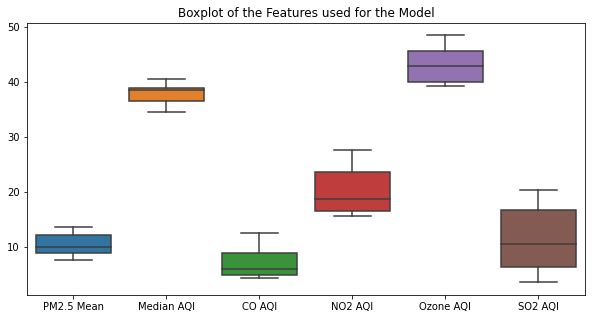

In [123]:
plt.figure(figsize=(10,5))
plt.title("Boxplot of the Features used for the Model")
sns.boxplot(data = joined_all.loc[:,'PM2.5 Mean':'SO2 AQI']);

## EDA

We will proceed to analyze the colinearity of our features. To do so, we figured that plotting a heatmap of a correlation matrix would be the most efficient.

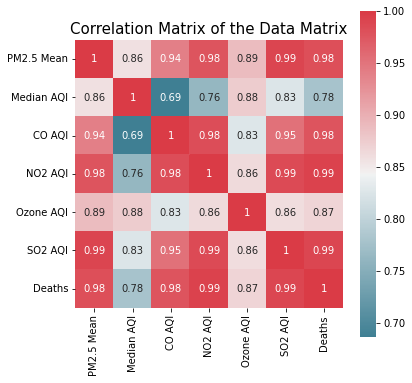

In [124]:
corr = joined_all.loc[:,'PM2.5 Mean':'Deaths'].corr()
#mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize=(6,6))
plt.title("Correlation Matrix of the Data Matrix", fontsize = 15)
sns.heatmap(joined_all.loc[:,'PM2.5 Mean':'Deaths'].corr(),cmap=cmap, annot=True, square=True);

In [125]:
from sklearn import linear_model as lm
import scipy as sc
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

model = lm.LinearRegression(fit_intercept=True)
X = joined_all.loc[:,['SO2 AQI', 'Median AQI', 'Ozone AQI']]
y = joined_all.loc[:,'Deaths']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

model.fit(X_train,y_train)
y_pred = model.predict(X_train)
y_valid = model.predict(X_test)

print("Coefficients of our model",model.coef_)
print("\nPerformance of the model")
print("Training set:\t Pearson coeff:",sc.stats.pearsonr(y_pred, y_train)[0],"\t RMSE:",np.sqrt(mse(y_pred, y_train)))
print("Training set:\t Pearson coeff:",sc.stats.pearsonr(y_valid, y_test)[0],"\t RMSE:",np.sqrt(mse(y_valid, y_test)))

Coefficients of our model [ 2634.68354417 -2512.60138506  1324.39548394]

Performance of the model
Training set:	 Pearson coeff: 0.9966458391107427 	 RMSE: 1039.00789047106
Training set:	 Pearson coeff: 0.9956222127438712 	 RMSE: 2389.246464490017


# Inferencing deaths in the US from air pollution

Since we drawn the performance of our model above as good, we will train the Linear Model on all data points from 2000 to 2019. Once we are done, we are going to estimate the 2020 death rate attributed to air pollution.

In [129]:
model = lm.LinearRegression(fit_intercept=True)
X = joined_all.loc[:,['SO2 AQI', 'Median AQI', 'Ozone AQI']]
y = joined_all.loc[:,'Deaths']

model.fit(X,y)
print("Coefficients of our model",model.coef_)
print("\nPerformance of the model")
print("Training set:\t Pearson coeff:",sc.stats.pearsonr(y, model.predict(X))[0],"\t RMSE:",np.sqrt(mse(y, model.predict(X))))

Coefficients of our model [ 2770.15121732 -1990.20379279  1076.01593257]

Performance of the model
Training set:	 Pearson coeff: 0.9951569943590648 	 RMSE: 1506.9840972525394


In [130]:
partial_join = pm25_filtered
dfs_to_join = [annual_aqi_us_filtered,co_concentration,no2_concentration,ozone_concentration,so2_concentration]

for df in dfs_to_join:
    partial_join = partial_join.merge(right=df,left_on='Year',right_on='Year')

partial_join

,Year,PM2.5 Mean,Median AQI,CO AQI,NO2 AQI,Ozone AQI,SO2 AQI
0,2000,13.497383,39.700441,12.536678,27.491528,45.949634,20.215974
1,2001,13.225067,39.335074,11.818071,26.929423,47.056199,19.220851
2,2002,12.827120,38.721453,10.889842,25.932520,48.392076,17.658397
3,2003,12.332006,38.533104,10.349962,25.004868,45.508254,17.528784
4,2004,12.023175,37.500871,9.350434,23.438959,42.283625,16.750093
5,2005,12.868947,39.577797,8.662587,23.754289,46.045732,16.671852
6,2006,11.622669,38.954464,8.126856,22.775990,45.465603,14.980272
7,2007,11.920433,40.444946,7.137915,21.902248,45.932088,14.083842
8,2008,10.891642,38.860000,6.471224,21.095123,43.395879,13.361089
9,2009,9.883770,36.533212,6.055578,19.085690,39.535504,10.799102


In [142]:
deaths_in_2020 = model.predict(partial_join.loc[partial_join['Year']==2020,['SO2 AQI', 'Median AQI', 'Ozone AQI']])[0]

print('We predict {} persons died from air pollution in the US in 2020'.format(np.ceil(deaths_in_2020)))

We predict 58708.0 persons died from air pollution in the US in 2020


## Trend of death rate attributed to air pollution

Now that our inference is done, we can plot the trend of death rate attributed to air pollution in the US from the years 2000 to 2020

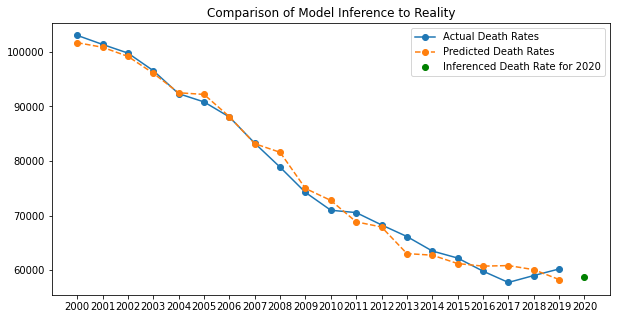

In [164]:
plt.figure(figsize=(10,5))
plt.plot(joined_all['Year'], joined_all['Deaths'], '-o',label='Actual Death Rates')
plt.plot(joined_all['Year'], model.predict(X),'--o',label='Predicted Death Rates')
plt.scatter(2020, deaths_in_2020, color='green', label='Inferenced Death Rate for 2020')
plt.xticks(np.arange(min(joined_all['Year']), max(joined_all['Year'])+2, 1.0))
plt.title('Comparison of Model Inference to Reality')
plt.legend();